In [1]:
from data_preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb

from sklearn.preprocessing import MinMaxScaler
import cdt
import networkx as nx

# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting settings
sns.set_style("ticks", rc={"font.size": 11})
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 11})

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#### Warning

This notebook requires the Causal Discovery Toolbox (cdt), which combines Python and R packages. See their documentation for an installation guide: https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html

# 4. Causal Relationship Discovery

In [110]:
# read in data, filtered to super contigs
SIGNIFICANCE_LEVEL = 1e-04  # fewer contigs: 1e-05; more contigs: 1e-03

df = pd.read_csv('Results/Contigs_with_classwise_t-tests_and_distributions.csv')
df = df[df['p-value'] <= SIGNIFICANCE_LEVEL]
df_gene = df_cpm[df['Contig']].join(df_CH4DMI, how='inner')

In [111]:
# normalize so that each sample's contigs add up to 1
df_gene_norm = df_gene
df_gene_norm[df_gene.columns[:-1]] = df_gene[df_gene.columns[:-1]].div(df_gene[df_gene.columns[:-1]].sum(axis=1), axis=0)

In [112]:
# minmax scale methane output
mms = MinMaxScaler()
df_gene_norm[df_gene.columns[-1:]] = mms.fit_transform(df_gene_norm[df_gene.columns[-1:]])

In [165]:
df_gene_norm.rename(columns={"CH4 g/kg DMI_average": "CH4 g/kg DMI"}, inplace=True)

#### Obtaining a graph skeleton to reduce the computational burden later

In [166]:
# Graph Lasso to obtain a graph skeleton
SKEL_ALPHA = 0.001
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(df_gene_norm, alpha=SKEL_ALPHA)

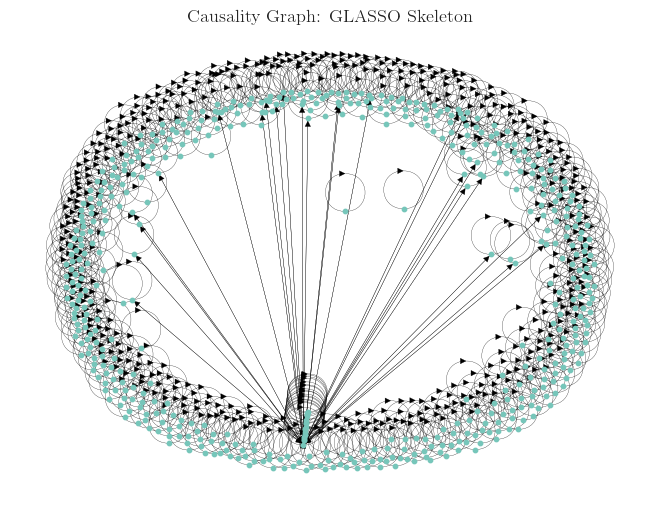

In [167]:
# plot
pos = nx.spring_layout(skeleton, seed=2210)

nx.draw(skeleton, pos, edge_color='black', width=0.2, node_size=10, node_color=sns.color_palette("BrBG", 6).as_hex()[4])
# nx.draw_networkx_labels(skeleton, pos, font_size=5, font_family="serif")

plt.title('Causality Graph: GLASSO Skeleton')
plt.show()

#### Greedy Equivalence Search (GES)

In [168]:
model = cdt.causality.graph.GES()
output_graph = model.predict(df_gene_norm, skeleton)

GES is ran on the skeleton of the given graph.


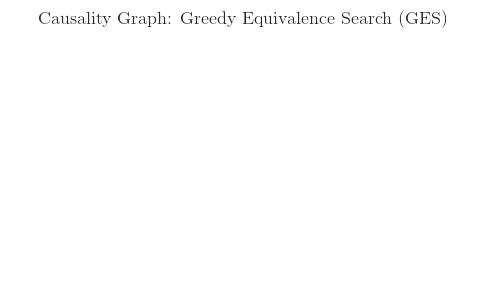

In [169]:
# filter on connected nodes only
l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
connected_nodes = [item for row in filtered_l for item in row]
H = output_graph.subgraph(connected_nodes)
pos = nx.kamada_kawai_layout(H)
labels = {node: node for node in H.nodes}

fig, ax = plt.subplots(1, figsize=(5, 3))
nx.draw(H, pos, edge_color='black', width=0.2, node_size=50, 
        node_color=sns.color_palette("BrBG", 6).as_hex()[4],
        with_labels=False)
nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                        horizontalalignment='left', font_size=10,
                        clip_on=False)

plt.title('Causality Graph: Greedy Equivalence Search (GES)')
plt.tight_layout()
plt.savefig("Plots/Causality_GES_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
plt.show()

#### Peter-Clark (PC)

PC is ran on the skeleton of the given graph.


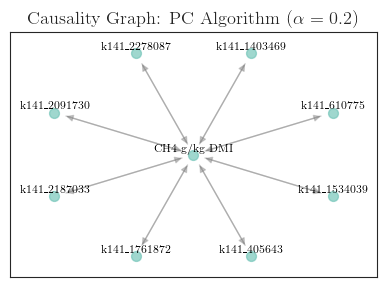

PC is ran on the skeleton of the given graph.


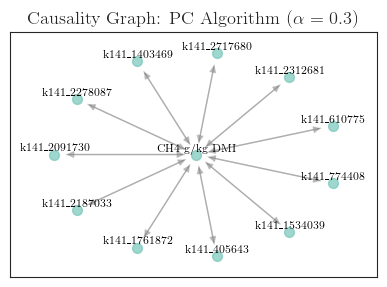

PC is ran on the skeleton of the given graph.


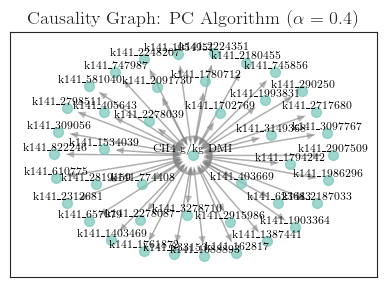

PC is ran on the skeleton of the given graph.


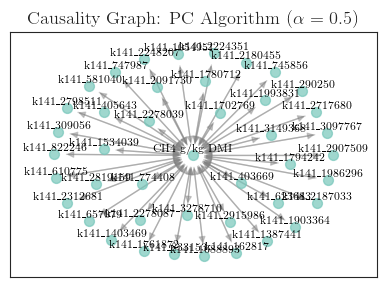

In [177]:
for PC_ALPHA in np.linspace(0.2, 0.5, 4):
    model = cdt.causality.graph.PC(alpha=PC_ALPHA)
    output_graph = model.predict(df_gene_norm, skeleton)

    # filter on connected nodes only
    l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
    filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
    connected_nodes = [item for row in filtered_l for item in row]
    H = output_graph.subgraph(connected_nodes)
    pos = nx.kamada_kawai_layout(H)
    labels = {node: node for node in H.nodes}

    fig, ax = plt.subplots(1, figsize=(4, 3))
    nx.draw_networkx_nodes(H, pos, alpha=0.7, node_size=50, 
            node_color=sns.color_palette("BrBG", 6).as_hex()[4])
    nx.draw_networkx_edges(H, pos, alpha=0.4, width=1, edge_color='gray')
    nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                            horizontalalignment='center', font_size=8,
                            clip_on=True)

    plt.title(r'Causality Graph: PC Algorithm ($\alpha = $ '+"{:.1f}".format(PC_ALPHA)+')')
    plt.tight_layout()
    plt.margins(x=0.1)
    plt.savefig("Plots/Causality_PC_"+str(PC_ALPHA)+"_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
    plt.show()

#### Removing methane output

In [178]:
df_gene_norm_nometh = df_gene_norm[df_gene_norm.columns[:-1]]

In [179]:
# Graph Lasso to obtain a graph skeleton
SKEL_ALPHA = 0.0005
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(df_gene_norm_nometh, alpha=SKEL_ALPHA)

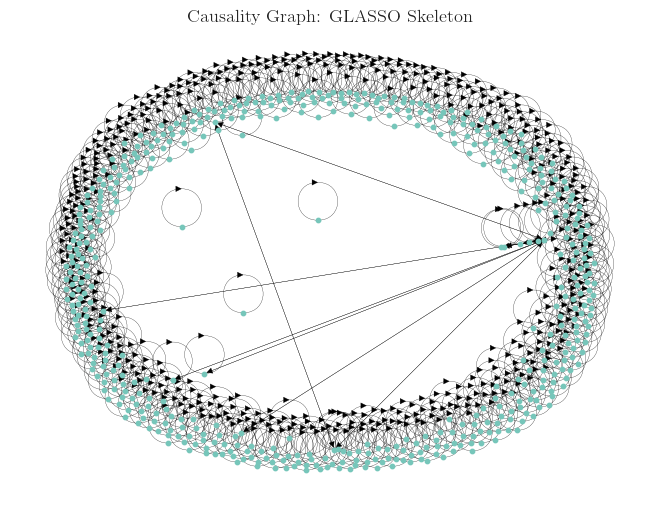

In [180]:
# plot
pos = nx.spring_layout(skeleton, seed=2210)

nx.draw(skeleton, pos, edge_color='black', width=0.2, node_size=10, node_color=sns.color_palette("BrBG", 6).as_hex()[4])
# nx.draw_networkx_labels(skeleton, pos, font_size=5, font_family="serif")

plt.title('Causality Graph: GLASSO Skeleton')
plt.show()

PC is ran on the skeleton of the given graph.


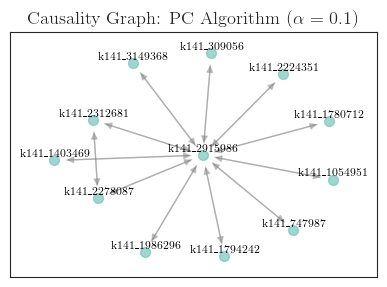

PC is ran on the skeleton of the given graph.


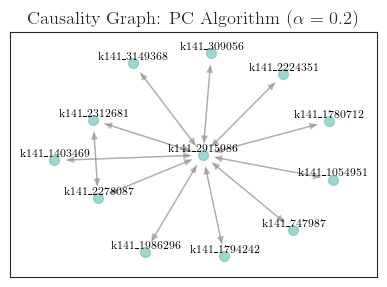

PC is ran on the skeleton of the given graph.


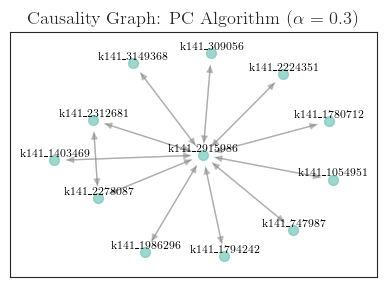

PC is ran on the skeleton of the given graph.


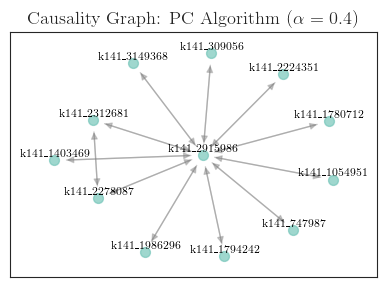

In [183]:
for PC_ALPHA in np.linspace(0.1, 0.4, 4):
    model = cdt.causality.graph.PC(alpha=PC_ALPHA)
    output_graph = model.predict(df_gene_norm_nometh, skeleton)

    # filter on connected nodes only
    l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
    filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
    connected_nodes = [item for row in filtered_l for item in row]
    H = output_graph.subgraph(connected_nodes)
    pos = nx.kamada_kawai_layout(H)
    labels = {node: node for node in H.nodes}

    fig, ax = plt.subplots(1, figsize=(4, 3))
    nx.draw_networkx_nodes(H, pos, alpha=0.7, node_size=50, 
            node_color=sns.color_palette("BrBG", 6).as_hex()[4])
    nx.draw_networkx_edges(H, pos, alpha=0.4, width=1, edge_color='gray')
    nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                            horizontalalignment='center', font_size=8,
                            clip_on=True)

    plt.title(r'Causality Graph: PC Algorithm ($\alpha = $ '+"{:.1f}".format(PC_ALPHA)+')')
    plt.tight_layout()
    plt.margins(x=0.1)
    plt.savefig("Plots/Causality_PC_"+str(PC_ALPHA)+"_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
    plt.show()

#### GIES

In [127]:
from cdt.causality.graph import GIES

In [128]:
model = GIES()
output_graph = obj.predict(df_gene_norm, skeleton)

GIES is ran on the skeleton of the given graph.


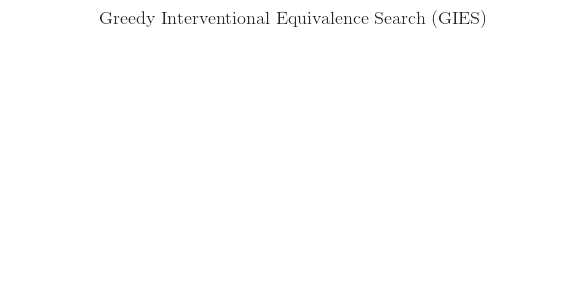

In [129]:
# filter on connected nodes only
l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
connected_nodes = [item for row in filtered_l for item in row]
H = output_graph.subgraph(connected_nodes)
pos = nx.kamada_kawai_layout(H)
labels = {node: node for node in H.nodes}

fig, ax = plt.subplots(1, figsize=(6, 3))
nx.draw(H, pos, edge_color='black', width=0.2, node_size=50, 
        node_color=sns.color_palette("BrBG", 6).as_hex()[4],
        with_labels=False)
nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                        horizontalalignment='left', font_size=10,
                        clip_on=False)

plt.title('Greedy Interventional Equivalence Search (GIES)')
plt.tight_layout()
plt.savefig("Plots/Causality_GIES_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
plt.show()

#### LiNGAM

In [130]:
from cdt.causality.graph import LiNGAM

In [131]:
model = LiNGAM()
output_graph = obj.predict(df_gene_norm, skeleton)

GIES is ran on the skeleton of the given graph.


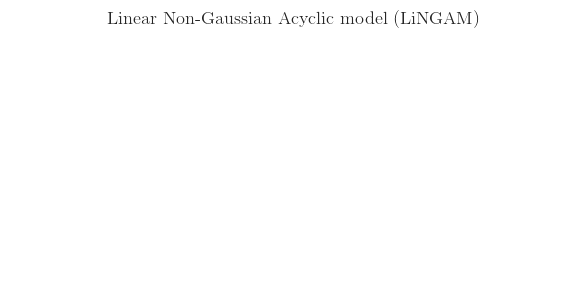

In [132]:
# filter on connected nodes only
l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
connected_nodes = [item for row in filtered_l for item in row]
H = output_graph.subgraph(connected_nodes)
pos = nx.kamada_kawai_layout(H)
labels = {node: node for node in H.nodes}

fig, ax = plt.subplots(1, figsize=(6, 3))
nx.draw(H, pos, edge_color='black', width=0.2, node_size=50, 
        node_color=sns.color_palette("BrBG", 6).as_hex()[4],
        with_labels=False)
nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                        horizontalalignment='left', font_size=10,
                        clip_on=False)

plt.title('Linear Non-Gaussian Acyclic model (LiNGAM)')
plt.tight_layout()
plt.savefig("Plots/Causality_LiNGAM_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
plt.show()

#### SAM

In [133]:
from cdt.causality.graph import SAM

In [134]:
model = SAM()
output_graph = obj.predict(df_gene_norm, skeleton)

GIES is ran on the skeleton of the given graph.


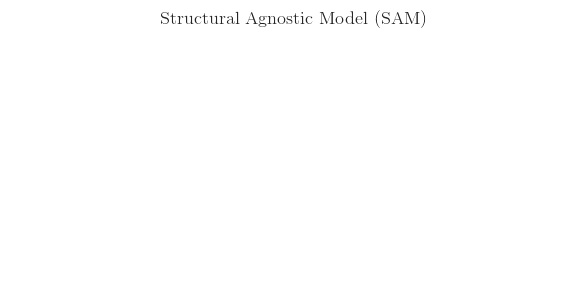

In [135]:
# filter on connected nodes only
l = [list(cc) for cc in nx.strongly_connected_components(output_graph)]
filtered_l = [inner_list for inner_list in l if len(inner_list) > 1]
connected_nodes = [item for row in filtered_l for item in row]
H = output_graph.subgraph(connected_nodes)
pos = nx.kamada_kawai_layout(H)
labels = {node: node for node in H.nodes}

fig, ax = plt.subplots(1, figsize=(6, 3))
nx.draw(H, pos, edge_color='black', width=0.2, node_size=50, 
        node_color=sns.color_palette("BrBG", 6).as_hex()[4],
        with_labels=False)
nx.draw_networkx_labels(H, pos, labels, verticalalignment="bottom", 
                        horizontalalignment='left', font_size=10,
                        clip_on=False)

plt.title('Structural Agnostic Model (SAM)')
plt.tight_layout()
plt.savefig("Plots/Causality_SAM_skeleton_"+str(SKEL_ALPHA)+".pdf", bbox_inches='tight')
plt.show()